# 🧬 Pseudo-Bulk Creation from Single-Cell Embeddings

This notebook loads single-cell embeddings (e.g., from scGPT or scFoundation), applies PCA, and aggregates them into pseudo-bulk profiles per sample or group.


In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import scanpy as sc

# === CONFIG ===
EMBED_PATH = "../../data/embeddings/scfoundation/pancancer_embeddings.npy"
META_PATH = "../../data/processed/pancancer_dimred.h5ad"  # or use .csv
GROUP_KEY = "SIDM"  # how to group cells into pseudo-bulk

print("📥 Loading embeddings and cell IDs...")
embeddings = np.load(EMBED_PATH)

print("📂 Loading metadata from AnnData...")
adata = sc.read(META_PATH)
cell_ids = adata.obs_names.to_numpy()

print(f"✅ Loaded {embeddings.shape[0]} embeddings with dim {embeddings.shape[1]}")


📥 Loading embeddings and cell IDs...
📂 Loading metadata from AnnData...
✅ Loaded 39715 embeddings with dim 3072


In [2]:
# Ensure cells are in the same order as the embeddings
adata = adata[cell_ids]
groups = adata.obs[GROUP_KEY]

print(f"🔢 Grouping by: {GROUP_KEY} ({groups.nunique()} groups)")


🔢 Grouping by: SIDM (140 groups)


🧠 Running PCA to 100 components...


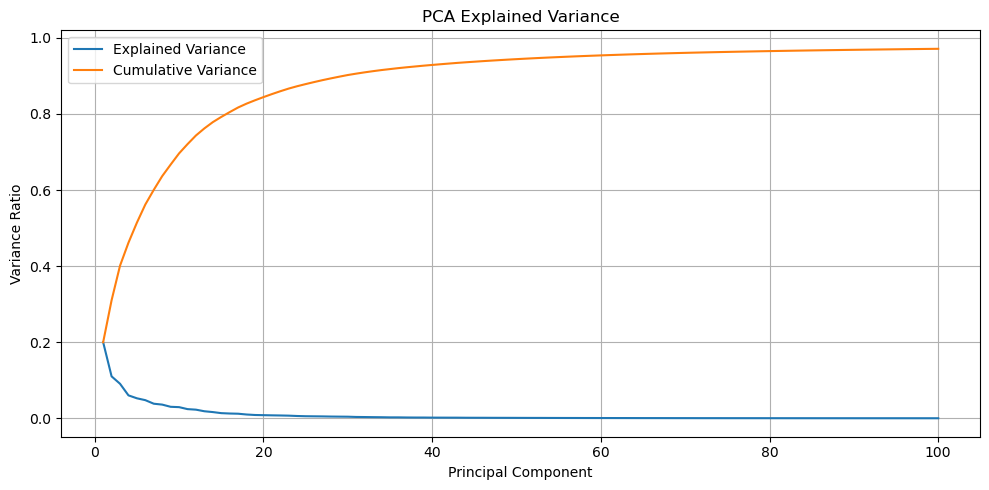

✅ 90% of variance explained by 30 PCs
✅ 95% of variance explained by 56 PCs
✅ 99% of variance explained by 1 PCs


In [3]:
import matplotlib.pyplot as plt

print("🧠 Running PCA to 100 components...")
MAX_PCS = 100
pca = PCA(n_components=MAX_PCS)
pca_emb = pca.fit_transform(embeddings)

# 📊 Plot explained variance
explained = pca.explained_variance_ratio_
cumulative = explained.cumsum()

plt.figure(figsize=(10, 5))
plt.plot(range(1, MAX_PCS + 1), explained, label="Explained Variance")
plt.plot(range(1, MAX_PCS + 1), cumulative, label="Cumulative Variance")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print how many components explain 90%, 95%, etc.
for threshold in [0.90, 0.95, 0.99]:
    n_comp = np.argmax(cumulative >= threshold) + 1
    print(f"✅ {threshold*100:.0f}% of variance explained by {n_comp} PCs")


In [4]:
print("🧠 Running PCA...")
N_PCS = 30
pca = PCA(n_components=N_PCS)
pca_emb = pca.fit_transform(embeddings)

pca_df = pd.DataFrame(
    pca_emb,
    index=groups.index,  # SIDM or SANGER_MODEL_ID
    columns=[f"PC{i+1}" for i in range(N_PCS)]
)

# Rename index for compatibility
pca_df.index.name = "SANGER_MODEL_ID"



🧠 Running PCA...


In [5]:
print("📊 Aggregating to pseudo-bulk format...")
pca_df = pd.DataFrame(pca_emb, index=cell_ids)
pca_df["group"] = groups.values

# Aggregate using mean
pseudo_bulk = pca_df.groupby("group").mean()
print(f"✅ Pseudo-bulk shape: {pseudo_bulk.shape}")


📊 Aggregating to pseudo-bulk format...
✅ Pseudo-bulk shape: (140, 30)


/tmp/ipykernel_1237956/3646088809.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudo_bulk = pca_df.groupby("group").mean()


In [6]:
# Rename index for consistency with tissue info
pseudo_bulk.index.name = "SANGER_MODEL_ID"
pseudo_bulk = pseudo_bulk.reset_index()  # Moves index to column

# Save as Parquet
pseudo_bulk.to_parquet("../../data/processed/pancancer_embeddings_30_pcs.parquet")
print("💾 Saved pseudo-bulk embeddings to 'pseudo_bulk_embeddings.parquet'")



/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


💾 Saved pseudo-bulk embeddings to 'pseudo_bulk_embeddings.parquet'
